In [1]:
from libraries import*

Welcome to JupyROOT 6.26/06
iminuit version: 2.17.0


**Define Lorentz func**

In [2]:

def lorentz(x, gamma, x0, A): #define lorentz fnc for single peak
    return (A*gamma/(np.pi*((x - x0)**2) + gamma**2))

def lorentz_multi(x, gamma, center, split, A): #define fnc for three peaks
    return lorentz(x, gamma, center - split, A) + lorentz(x, gamma, center, A) + lorentz(x, gamma, center + split, A)

def lorentz_cluster(x, gamma, center_1, split_1, center_2, split_2, A, offset): #define fnc for cluster of six peaks 
    return lorentz_multi(x, gamma, center_1, split_1, A) + lorentz_multi(x, gamma, center_2, split_2, A) + offset


**Plot variables**

In [20]:
steps = 32768
# x_start = 100.06
# x_end = -106.0
x_start = -106.0
x_end = 100.06
steps_ppm = (x_end - x_start)/steps
x = np.arange(x_start, x_end, steps_ppm)
# print(x)
# print(lorentz(x_end, Peak_width, cluster_2_center))

**Plotting Experimental Data**

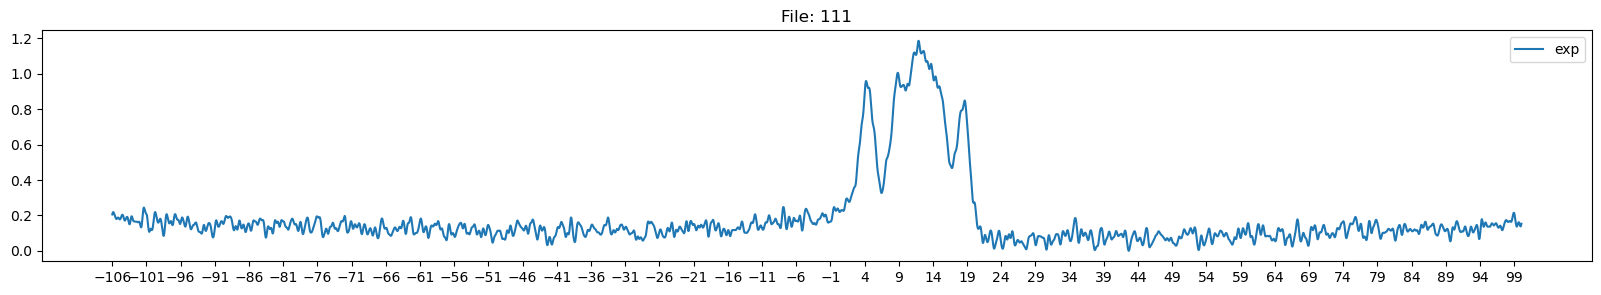

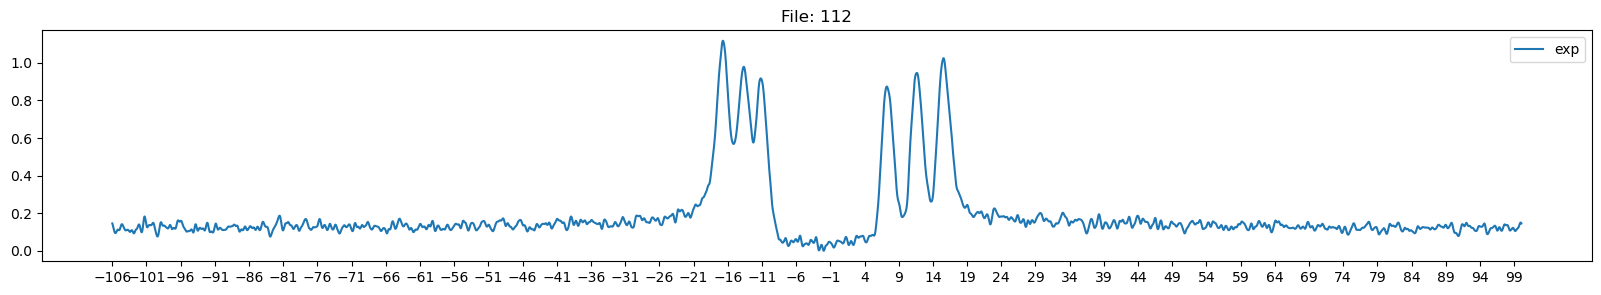

In [21]:
path = "/home/shiva/WMU/PhD/Data/text/" #output filepath
file_start = 111 #enter the first file number 
file_end = 112   #enter the last file number 
out_file_name = "fit_data"+str(file_start)+"_"+str(file_end)+".csv" #outfile name
for numb in range(file_start, file_end+1):
    yData = np.loadtxt(path+"SW_Shiva"+str(numb)+".txt", unpack=True ) # read in  
    yData = yData / max(yData)  # normalize
    yData = yData - min(yData)  # remove any vertical offset
    # Plot the experimental data
    plt.figure(figsize=(20,3))
    plt.plot(x, yData, '-', label="exp")
    plt.xticks(np.arange(min(x), max(x)+1,5.0)) 
    plt.title("File: "+str(numb))
    # plt.xlim([50,-80])  
    plt.legend()
    plt.show()

**Fitting Routine**

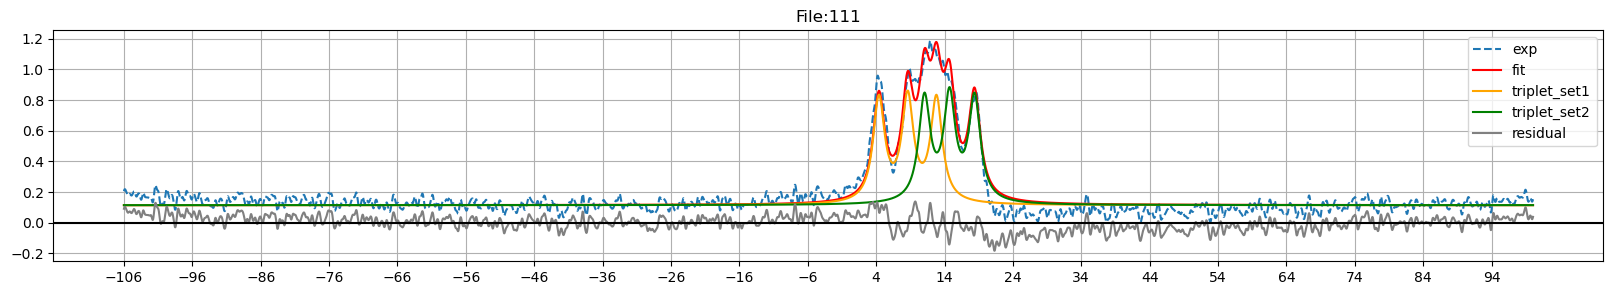

Results for data file SW_Shiva111.txt:
gamma = 1.8186151478155477
center_1 = 8.609149640138149
split_1 = 4.210892718847393
center_2 = 14.726884289778093
split_2 = 3.664773314557532
A = 1.2227563471706264
offset = 0.11417057730451609
Cluster 1 [4.671316623435687, 8.609149640138149, 12.546982656840612]
Cluster 2 [10.789051273075632, 14.726884289778093, 18.664717306480554]



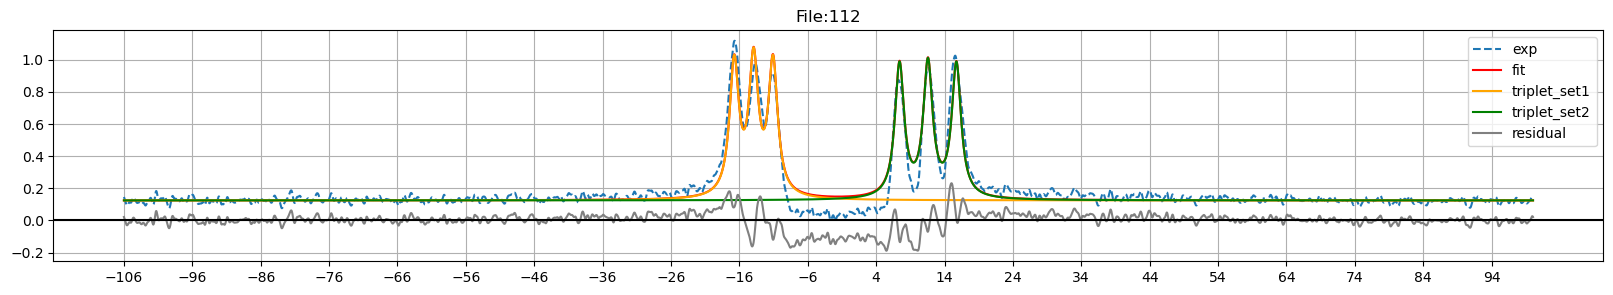

Results for data file SW_Shiva112.txt:
gamma = 1.4475882456394307
center_1 = -13.920979937306424
split_1 = 2.839087073040302
center_2 = 11.574808338866186
split_2 = 4.159699983245781
A = 1.196961974785465
offset = 0.12416890519106133
Cluster 1 [-17.420373465449465, -13.920979937306424, -10.421586409163382]
Cluster 2 [8.075414810723144, 11.574808338866186, 15.074201867009227]



In [25]:
#****************provide information of nucleus*********************************
s = 3/2 #spin of nuclei
clusters = 2 # magnetically different nuclei in unit cell
peaks = int(2*s)

#****************provide initial values*****************************************
initializer_list = [                                                                    
    {'gamma': 1, 'center_1': 20, 'split_1': 2, 'center_2': 20, 'split_2': 2, 'A': 1, 'offset': 0.18},
    {'gamma': 1, 'center_1': -15, 'split_1': 2, 'center_2': 10, 'split_2' : 2, 'A': 1, 'offset': 0.18}
    ]

for numb, initial_values in zip(range(file_start, file_end+1), initializer_list):
    yData = np.loadtxt("/home/shiva/WMU/PhD/Data/text/SW_Shiva"+str(numb)+".txt", unpack=True ) # read in  
    yData = yData / max(yData)  # normalize
    yData = yData - min(yData)  # remove any vertical offset
    least_squares = LeastSquares(x, yData, 0.1, lorentz_cluster)
    m = Minuit(least_squares, **initial_values).migrad()
    # corr_mat = (m.covariance.correlation())
    # print(corr_mat)
    # print(m.migrad())
    if m.values['split_1']>5 or m.values['split_2']> 5:
        print("\033[91mCheck!!!\033[0m")
    residual = yData - lorentz_cluster(x, *m.values) # finding residual
    triplet_1 = lorentz_multi(x, m.values['gamma'], m.values['center_1'], m.values['split_1'], m.values['A']) + m.values['offset']
    triplet_2 = lorentz_multi(x, m.values['gamma'], m.values['center_2'], m.values['split_2'], m.values['A']) + m.values['offset']

    #*****************Plotting************************************************
    plt.figure(figsize=(20,3))
    xinterval = np.arange(-50,10,10) 
    plt.plot(x, yData, '--', label="exp")
    plt.plot(x, lorentz_cluster(x, *m.values), label="fit", color = 'red')  
    plt.plot(x,triplet_1, label = "triplet_set1",color = "orange") 
    plt.plot(x,triplet_2, label = "triplet_set2",color = "green")
    plt.xticks(np.arange(min(x), max(x)+1, 10.0)) 
    plt.title("File:"+str(numb))
    plt.plot(x, residual, color = 'grey', label = "residual")
    plt.axhline(y = 0, xmin= x_start, xmax= x_end, color = 'black') #zero reference line
    # plt.xlim([50,-80]) 
    plt.grid()
    plt.legend()
    plt.show()

    # *****************Printing fit result*************************************
    print(f"Results for data file SW_Shiva{numb}.txt:")
    # print(m.migrad())
    for key, value in zip(m.parameters, m.values):
        print(f"{key} = {value}")

     # *****************Printing peak positions********************************
    cluster_1_center = m.values['center_1']
    cluster_2_center = m.values['center_2']
    Cluster_1_sep = m.values['split_1'] #separation of peaks in cluster 1
    Cluster_2_sep = m.values['split_2'] #separation of peaks in cluster 2
    peak_sep = np.mean([Cluster_1_sep, Cluster_2_sep]) #separation of peak
    peak_width = m.values['gamma']
    peak_height = m.values['A']
    parameter = [(cluster_1_center, peak_sep),(cluster_2_center, peak_sep)]
    peak_arrays = [[] for _ in range(len(parameter))]

    # Creating a list to store all rows before writing to CSV
    rows_to_write = []

    for id, (a,i) in enumerate(parameter):
        peak_array = []
        for j in range(-peaks+2, peaks-1):
            key = f"result{id + 1}_{j}"
            result = a + j * i
            peak_array.append(result)
        peak_arrays[id] = peak_array
        print(f"Cluster {id + 1}", peak_array)

    # Creating a dictionary for the current row
    row_dict = {'file': numb}
    for id, peak_array in enumerate(peak_arrays):
        row_dict[f"Cluster{id + 1}"] = peak_array

    # Appending the current row to the list
    rows_to_write.append(row_dict)
    with open (path+out_file_name, 'a') as csvfile:
        fieldnames = ['file', 'Cluster1', 'Cluster2']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Writing the headers only if the file is empty
        if csvfile.tell() == 0:
            writer.writeheader()
        writer.writerows(rows_to_write)
    print("\n" + "=" * 50)

    



In [24]:
cluster_1_center = m.values['center_1']
cluster_2_center = m.values['center_2']
Cluster_1_sep = m.values['split_1'] #separation of peaks in cluster 1
Cluster_2_sep = m.values['split_2'] #separation of peaks in cluster 2

peak_sep = np.mean([Cluster_1_sep, Cluster_2_sep]) #separation of peak

peak_width = m.values['gamma']
peak_height = m.values['A']
parameter = [(cluster_1_center, peak_sep),(cluster_2_center, peak_sep)]
peak_arrays = [[] for _ in range(len(parameter))]

for id, (a,i) in enumerate(parameter):
    peak_array = []
    for j in range(-peaks+2, peaks-1):
        key = f"result{id + 1}_{j}"
        result = a + j * i
        peak_array.append(result)
    peak_arrays[id] = peak_array
    print(f"Cluster {id + 1}", peak_array)


    

Cluster 1 [-17.420373465449465, -13.920979937306424, -10.421586409163382]
Cluster 2 [8.075414810723144, 11.574808338866186, 15.074201867009227]


[-15.         -14.64285714 -14.28571429 -13.92857143 -13.57142857
 -13.21428571 -12.85714286 -12.5        -12.14285714 -11.78571429
 -11.42857143 -11.07142857 -10.71428571 -10.35714286 -10.        ] 
 [-10.         -10.35714286 -10.71428571 -11.07142857 -11.42857143
 -11.78571429 -12.14285714 -12.5        -12.85714286 -13.21428571
 -13.57142857 -13.92857143 -14.28571429 -14.64285714 -15.        ]


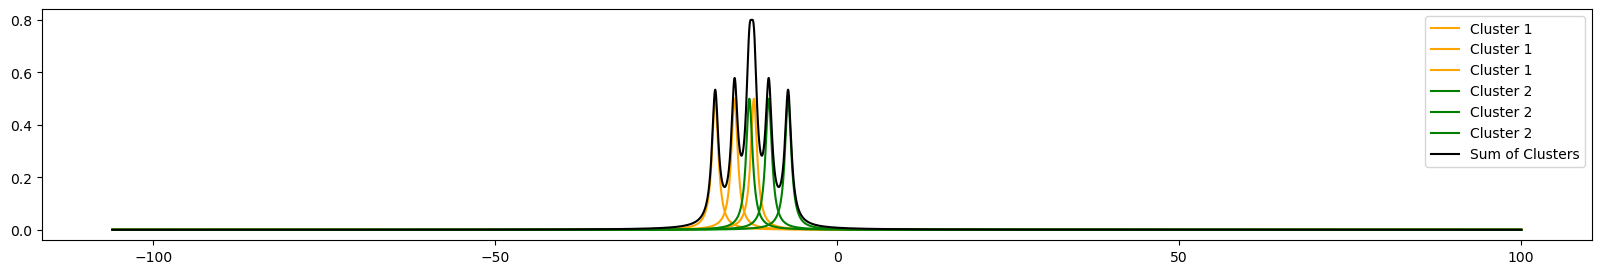

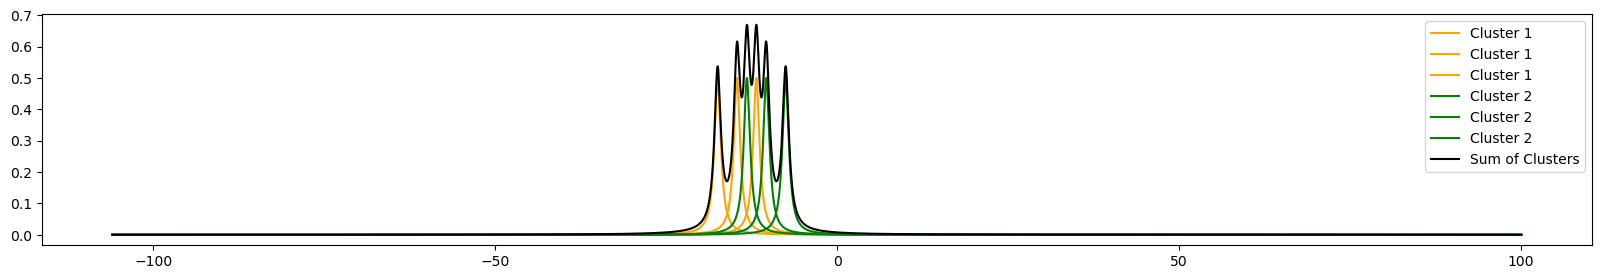

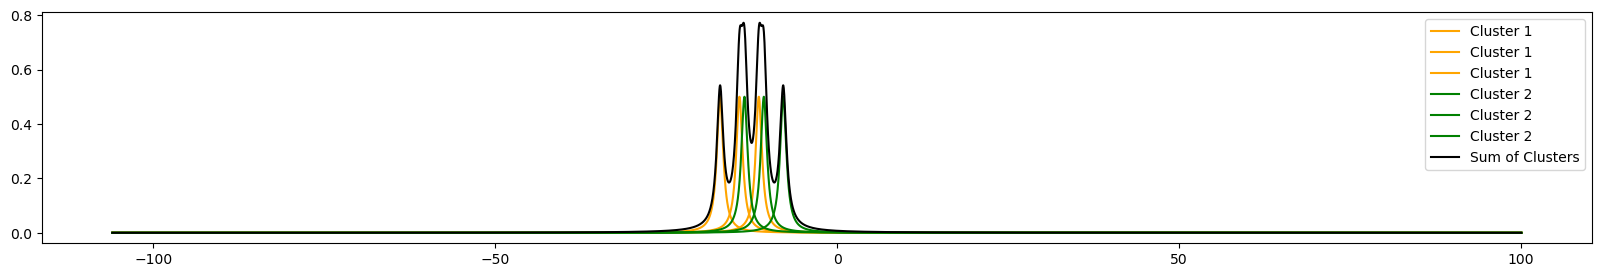

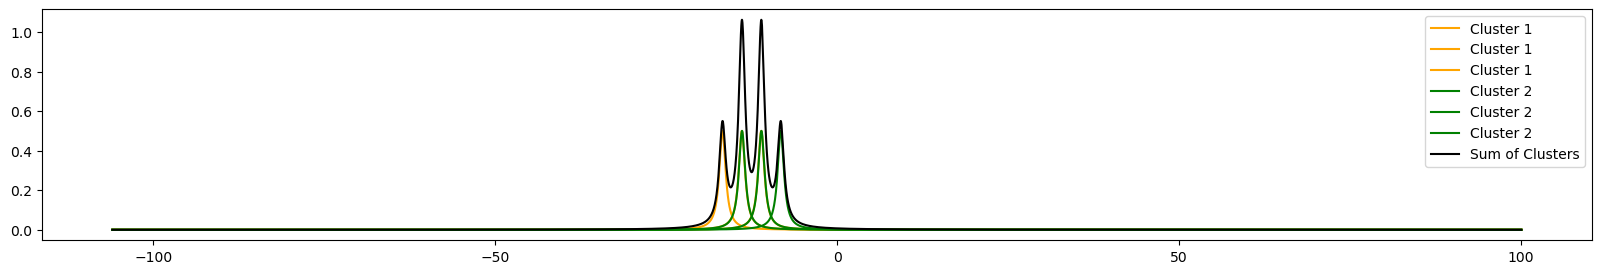

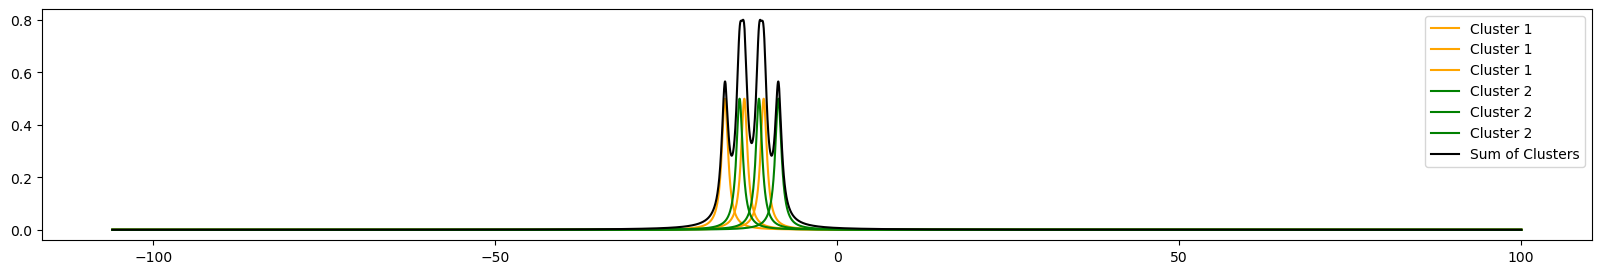

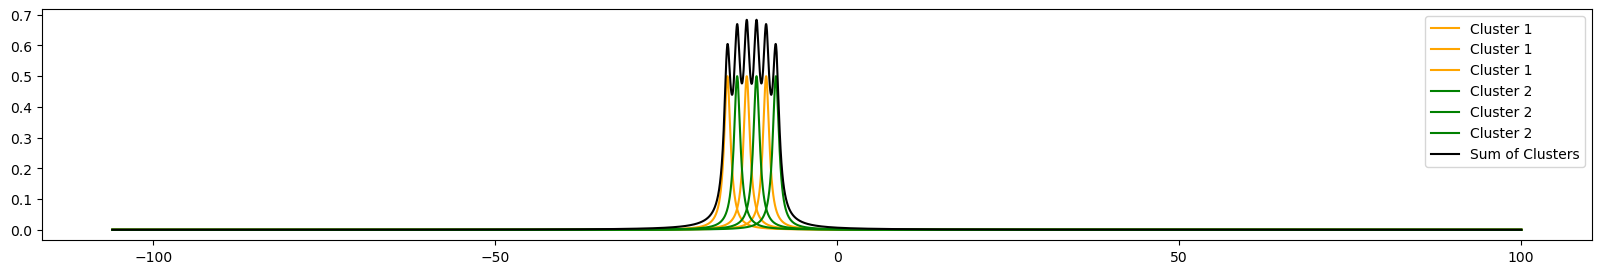

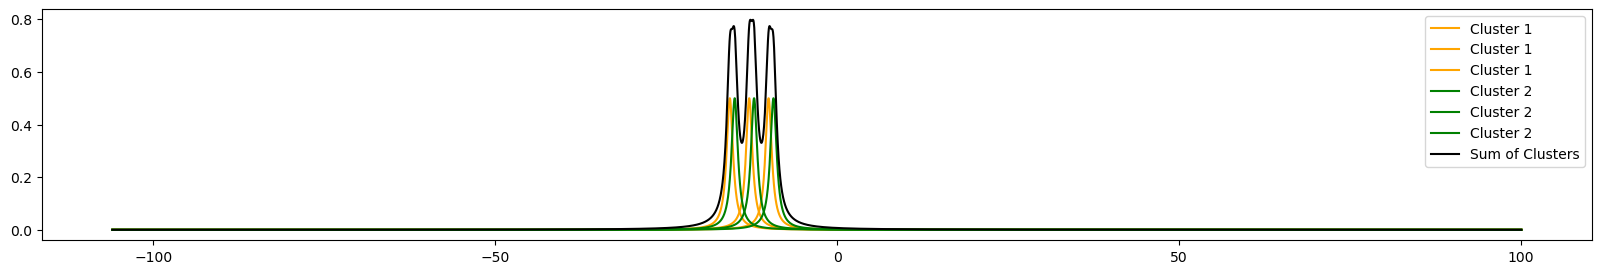

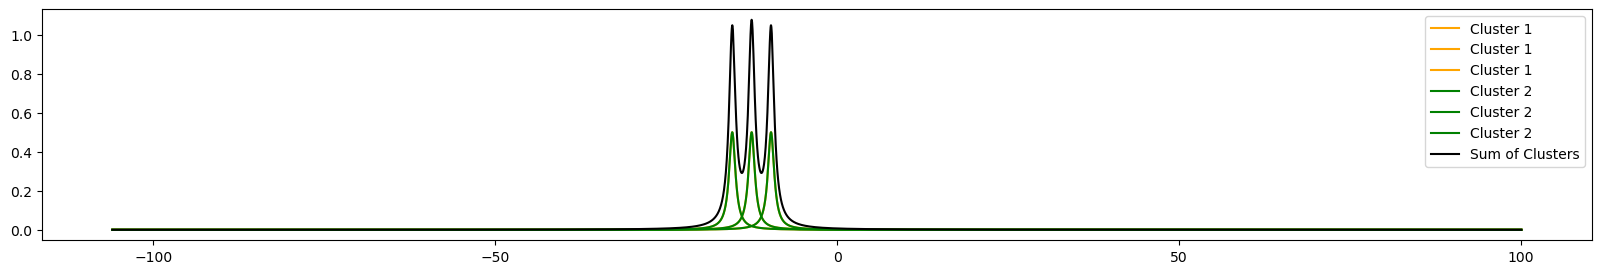

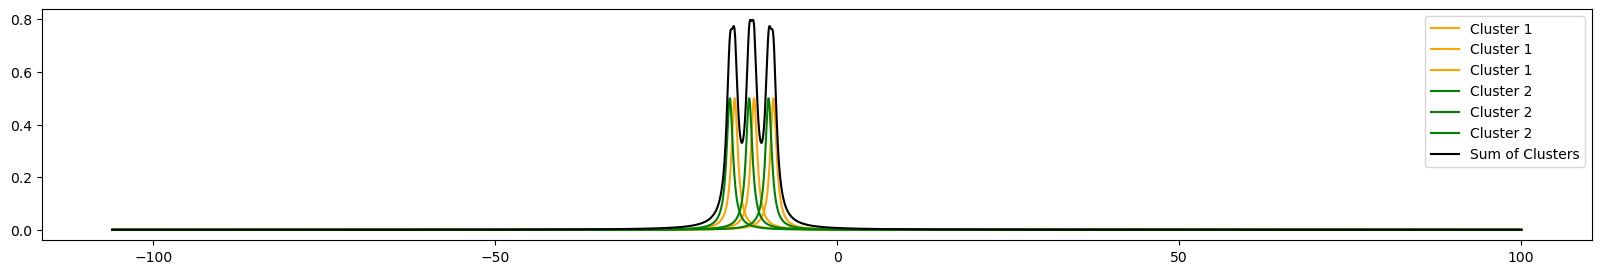

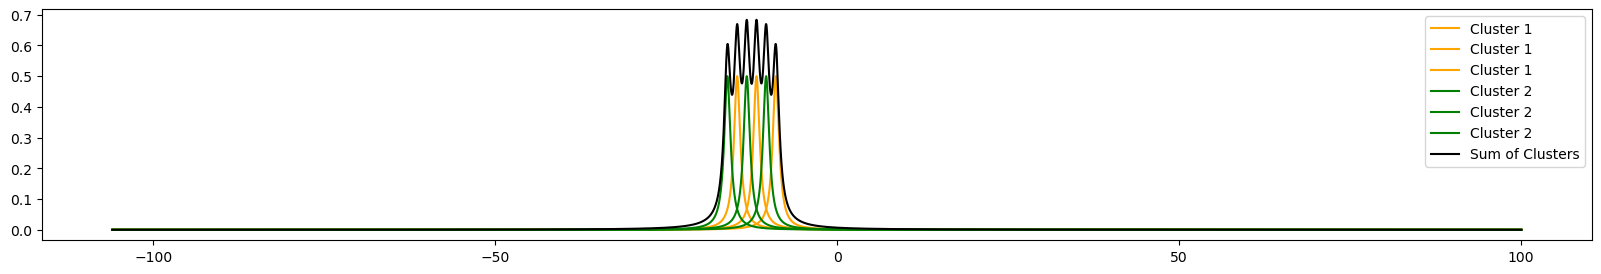

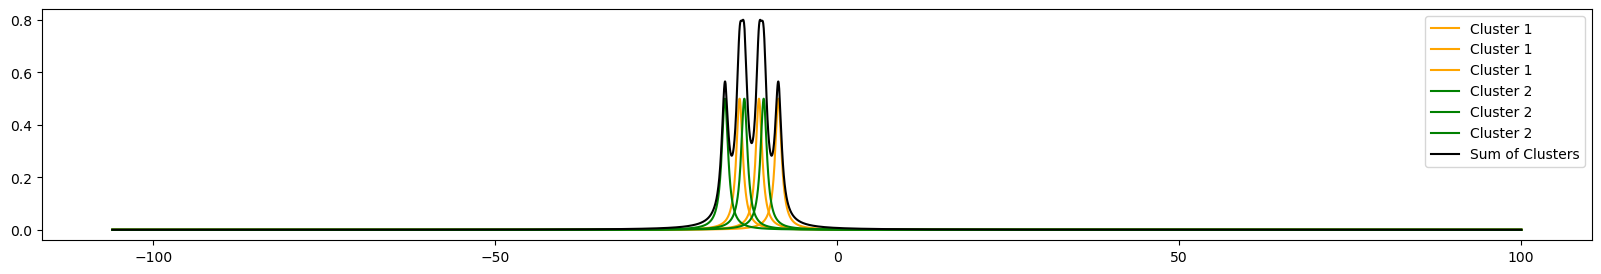

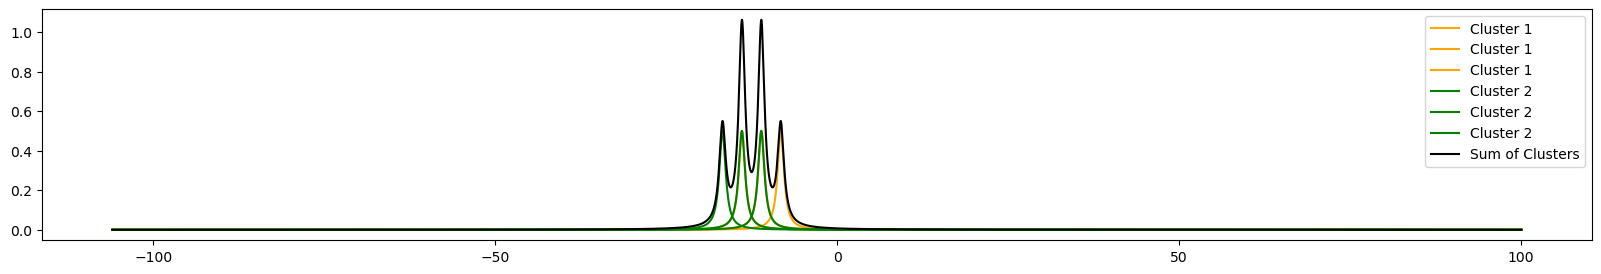

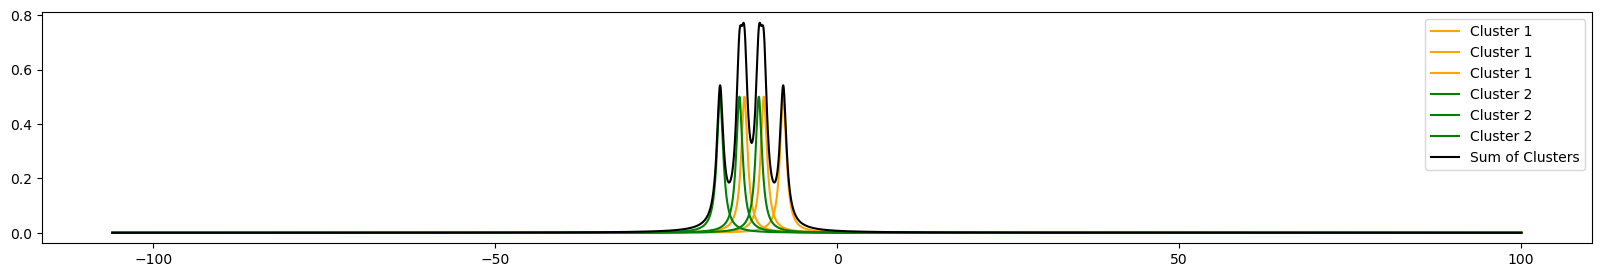

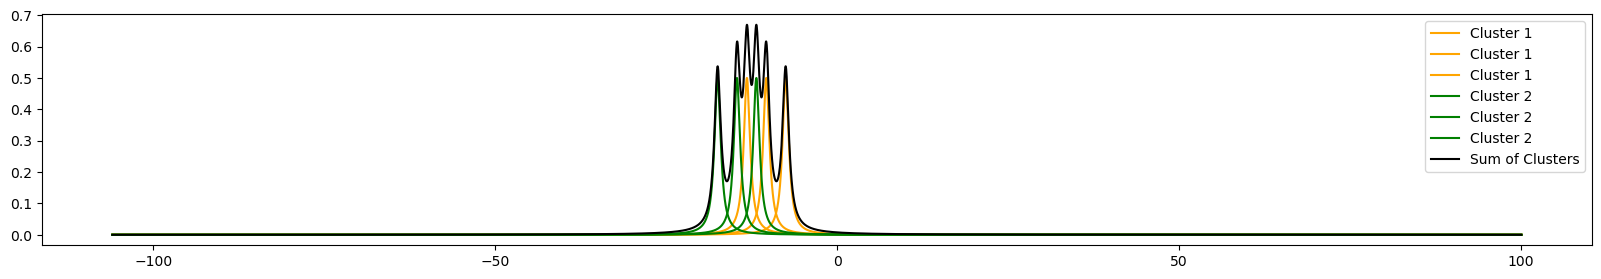

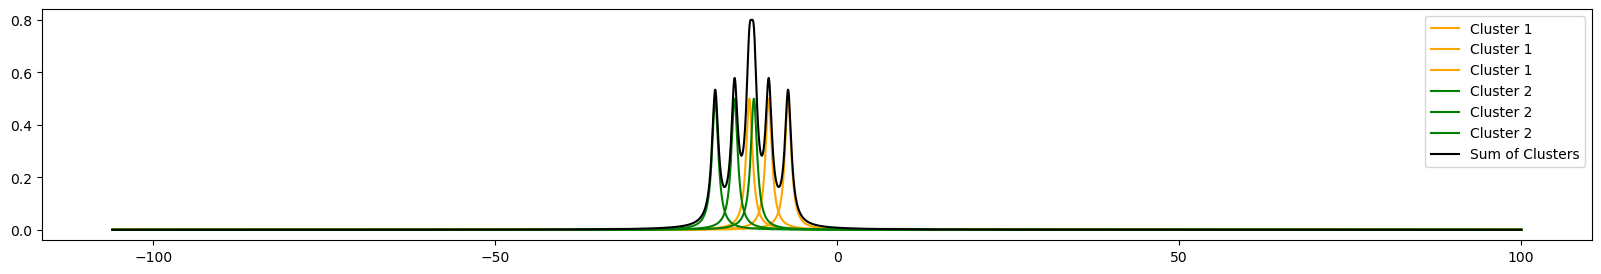

In [7]:

[cluster_1_centers,cluster_2_centers]  = [np.linspace(-15, -10, 15), np.linspace(-10, -15, 15)] # Varying centers for Cluster 1 and 2
# print(cluster_1_centers)
# cluster_2_centers = -np.linspace(0, 5, 15) # Varying centers for Cluster 2
print(cluster_1_centers, '\n', cluster_2_centers)

Cluster_1_sep = 2.852759257 #separation of peaks in cluster 1
Cluster_2_sep = 2.814838969 #separation of peaks in cluster 2

peak_sep = np.mean([Cluster_1_sep, Cluster_2_sep]) #separation of peak

peak_width = 1
peak_height = 0.5
for (cluster_1_center, cluster_2_center) in zip(cluster_1_centers, cluster_2_centers):
    parameter = [(cluster_1_center, peak_sep),(cluster_2_center, peak_sep)]
    peak_arrays = [[] for _ in range(len(parameter))]

    for id, (a,i) in enumerate(parameter):
        peak_array = []
        for j in range(-peaks+2, peaks-1):
            key = f"result{id + 1}_{j}"
            result = a + j * i
            peak_array.append(result)
        peak_arrays[id] = peak_array

    y_sum = np.zeros_like(x)
    plt.figure(figsize=(20,3))
    for id, (peak_array, color) in enumerate(zip(peak_arrays, ["orange", "green"])):
        for peak_center in peak_array:
            y = lorentz(x, gamma = peak_width, x0 = peak_center, A = peak_height)
            y_sum+= y
            plt.plot(x, y, label=f"Cluster {id + 1}", color=color)
            
            # print(f"Cluster {id + 1}, Peak Center: {peak_center}")

    plt.plot(x, y_sum, color = 'black', label="Sum of Clusters")

    plt.legend()

In [8]:
for id, peak_array in enumerate(peak_arrays):
    print(peak_array)
print(peak_arrays)

[-12.833799113000001, -10.0, -7.166200887]
[-17.833799113, -15.0, -12.166200886999999]
[[-12.833799113000001, -10.0, -7.166200887], [-17.833799113, -15.0, -12.166200886999999]]
